In [266]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.transpiler import CouplingMap
from qiskit.converters import dag_to_circuit
from qiskit.transpiler.layout import Layout
import numpy as np
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler.passes import (
    TrivialLayout,
    BasicSwap,
    ApplyLayout,
    SetLayout,
    SabreLayout,
    FullAncillaAllocation,
    EnlargeWithAncilla,
)
from qiskit.transpiler.passmanager import PassManager
from virtual_swap.sabre_swap import CNS_SabreSwap

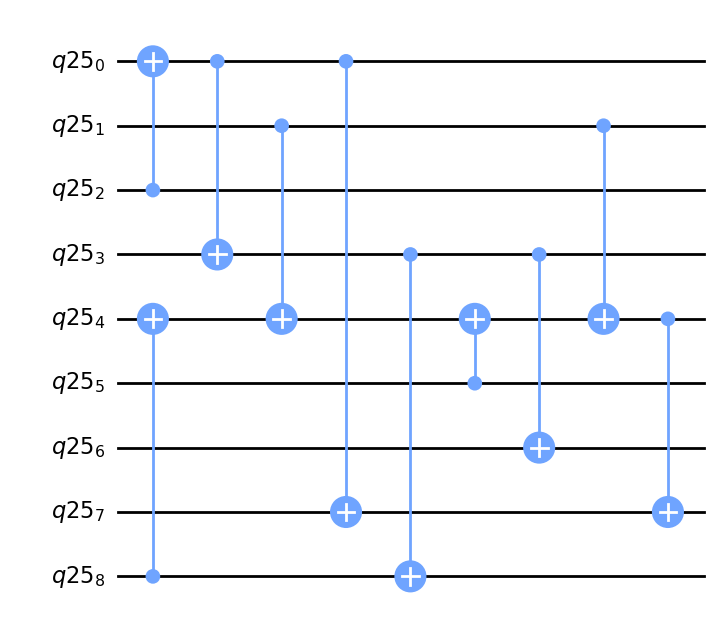

In [267]:
# load a dummy circuit
# generate network of random cnots
n, M = 3, 10
N = n**2
register = QuantumRegister(N)
qc = QuantumCircuit(register)

for _ in range(M):
    qc.cx(*np.random.choice(N, 2, replace=False))
qc.decompose().draw("mpl")

In [268]:
# load a dummy coupling map and layout
coupling = CouplingMap.from_grid(n, n)
layout = Layout({q: i for q, i in zip(register, range(N))})

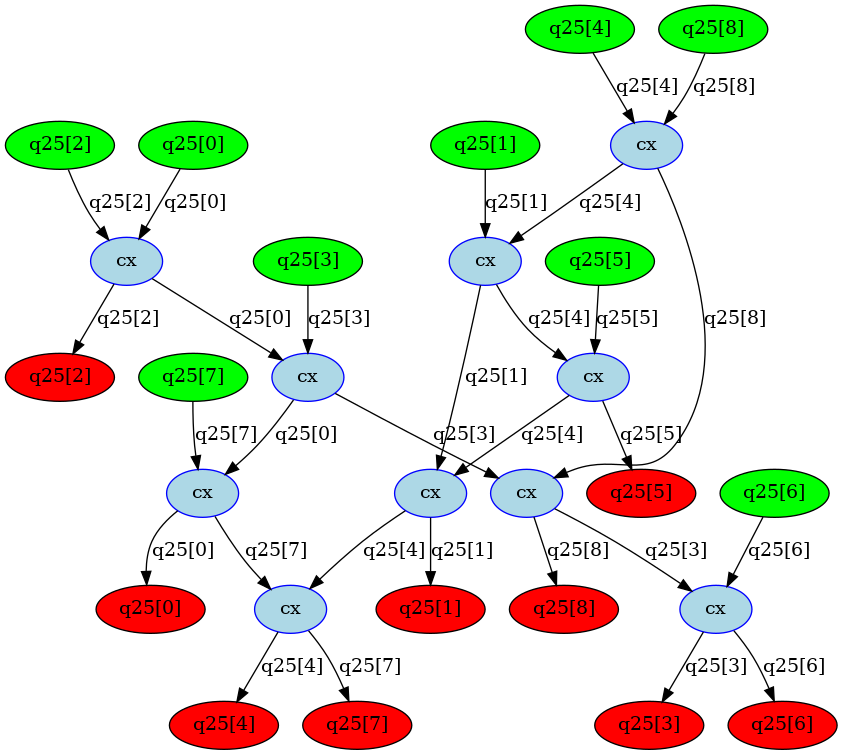

In [269]:
# print DAG
from qiskit.converters import circuit_to_dag

dag = circuit_to_dag(qc)
dag.draw("mpl")

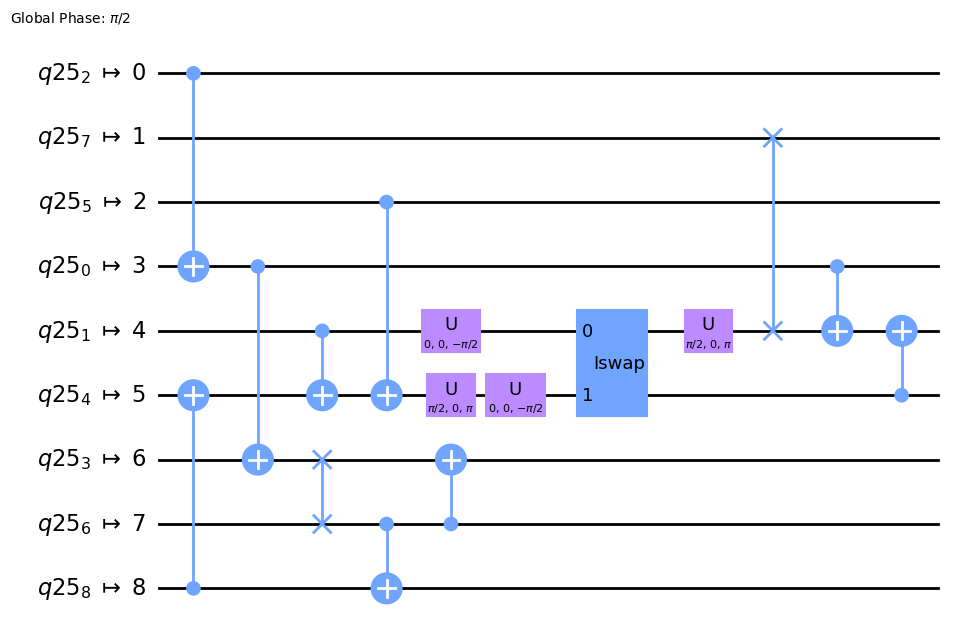

In [276]:
# make sure the old sabre python code works with our new qiskit version
pm = PassManager()
routing = CNS_SabreSwap(coupling, heuristic="decay")
pm.append(SabreLayout(coupling, routing_pass=routing))
# pm.append(TrivialLayout(coupling))
pm.append([FullAncillaAllocation(coupling), EnlargeWithAncilla(), ApplyLayout()])


pm.append(routing)
pm.append(Unroller(["u", "cx", "iswap", "swap"]))
qc_swapped = pm.run(qc)
qc_swapped.draw("mpl")

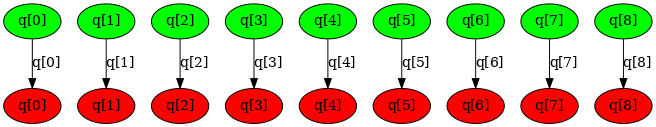

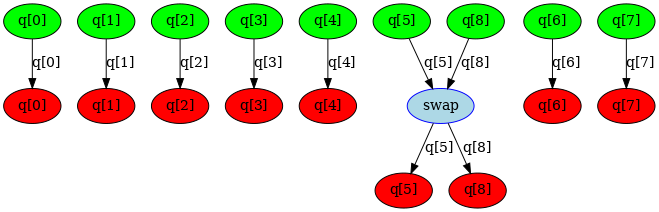

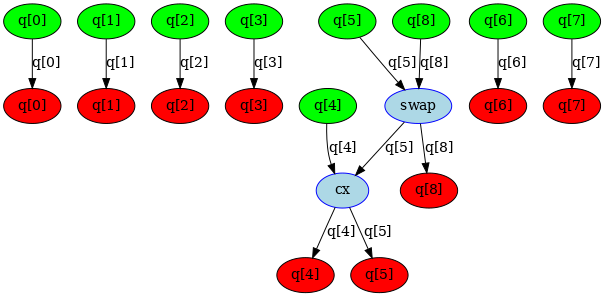

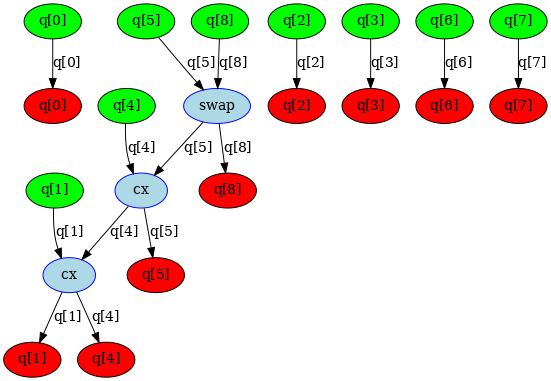

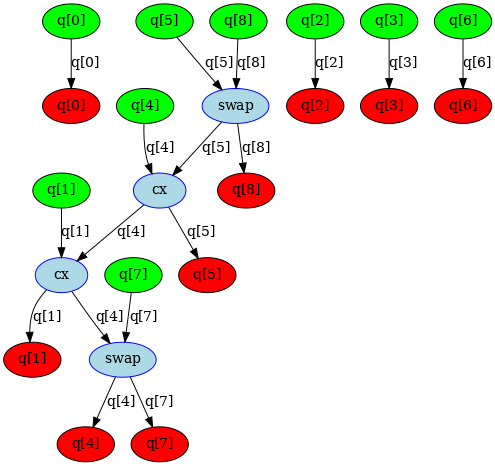

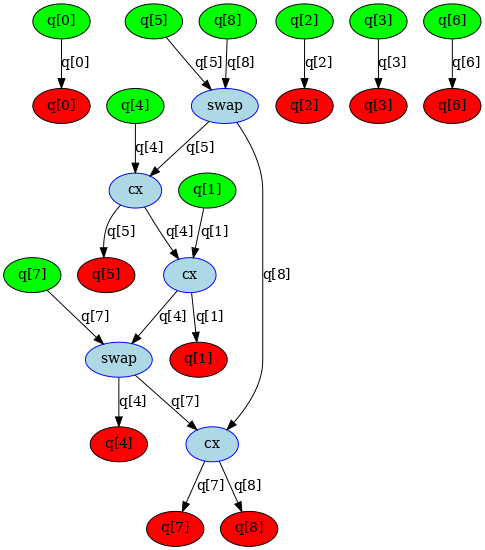

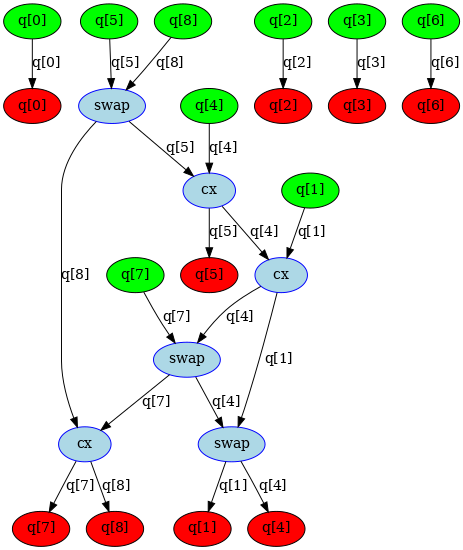

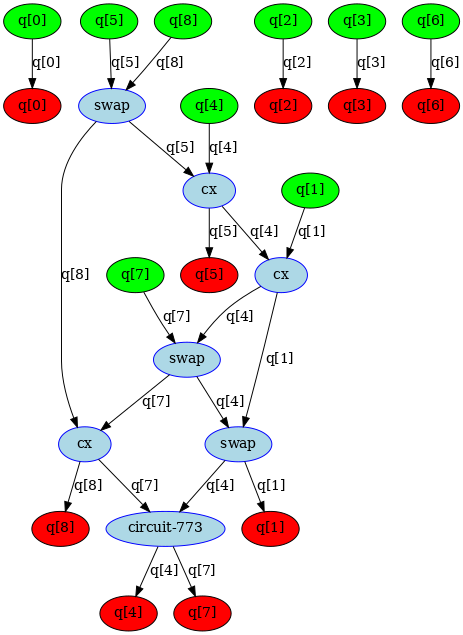

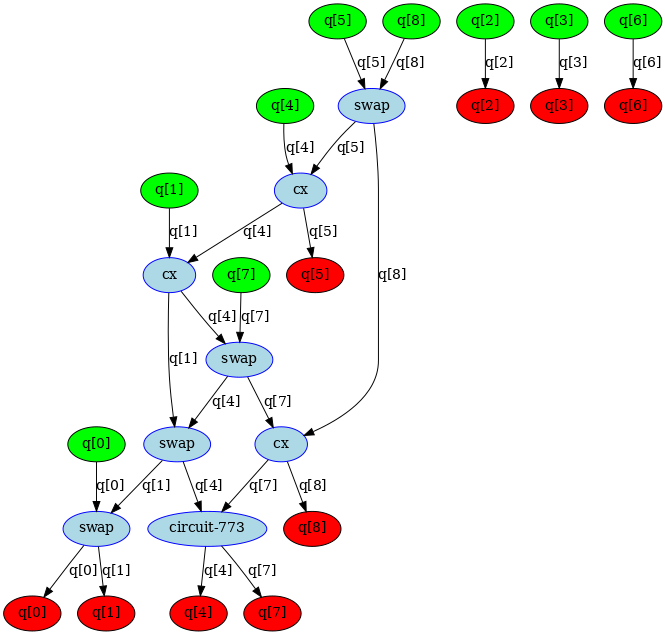

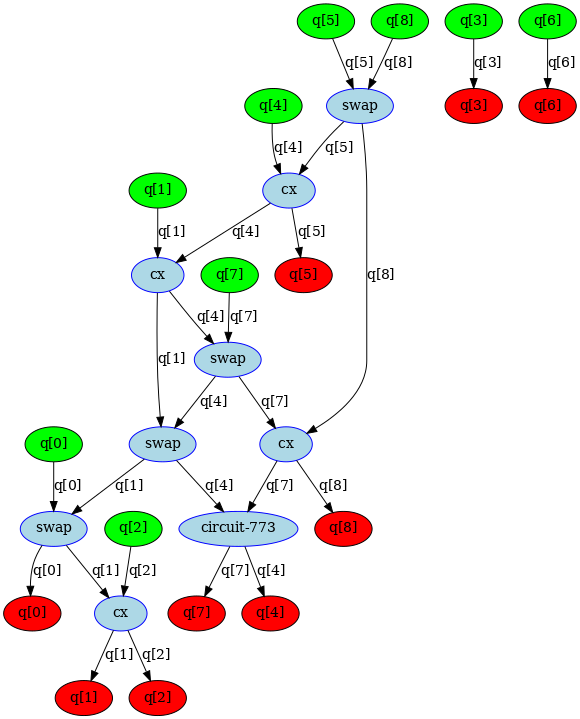

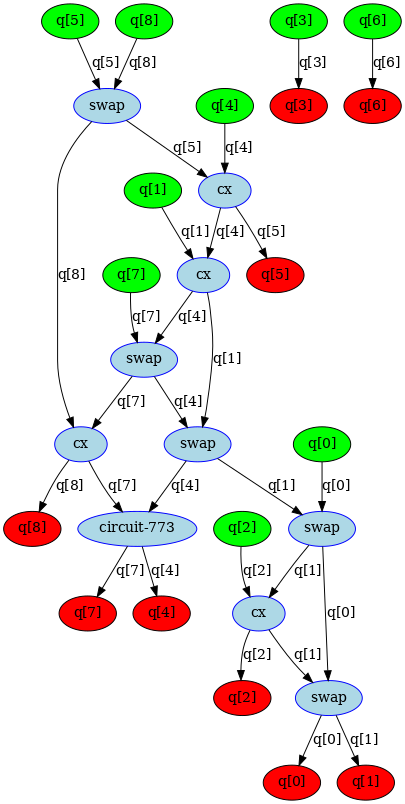

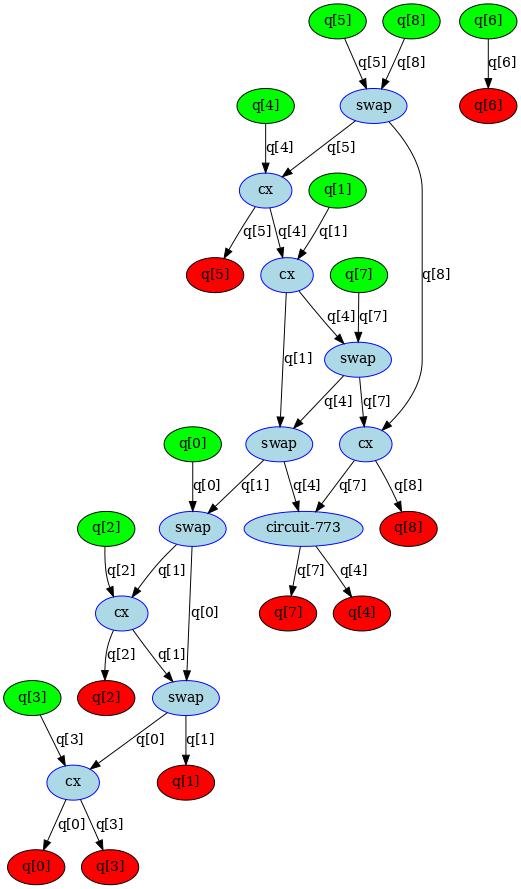

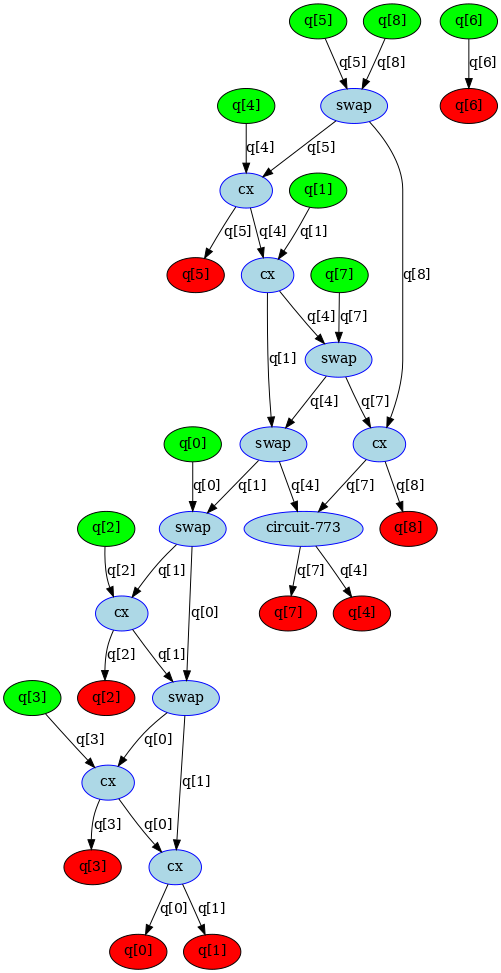

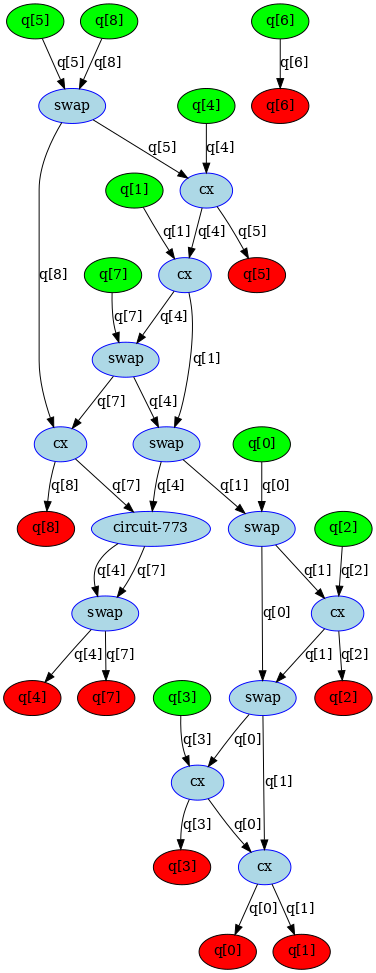

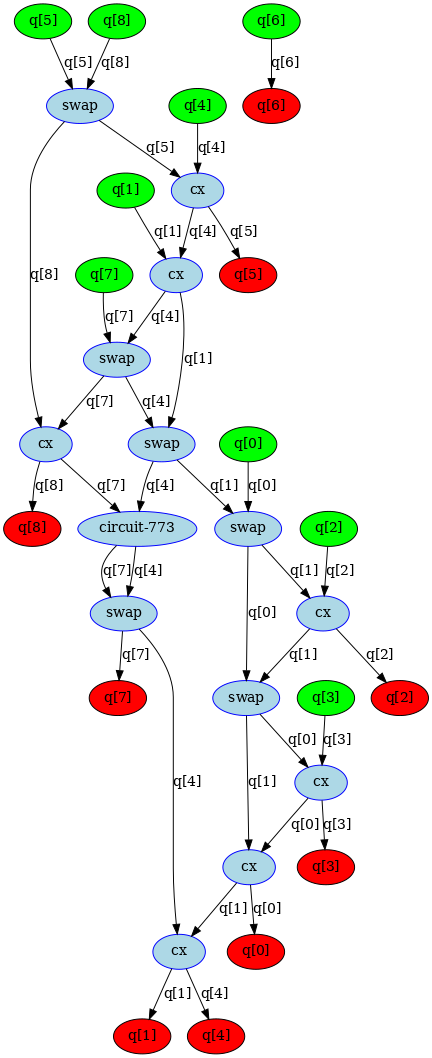

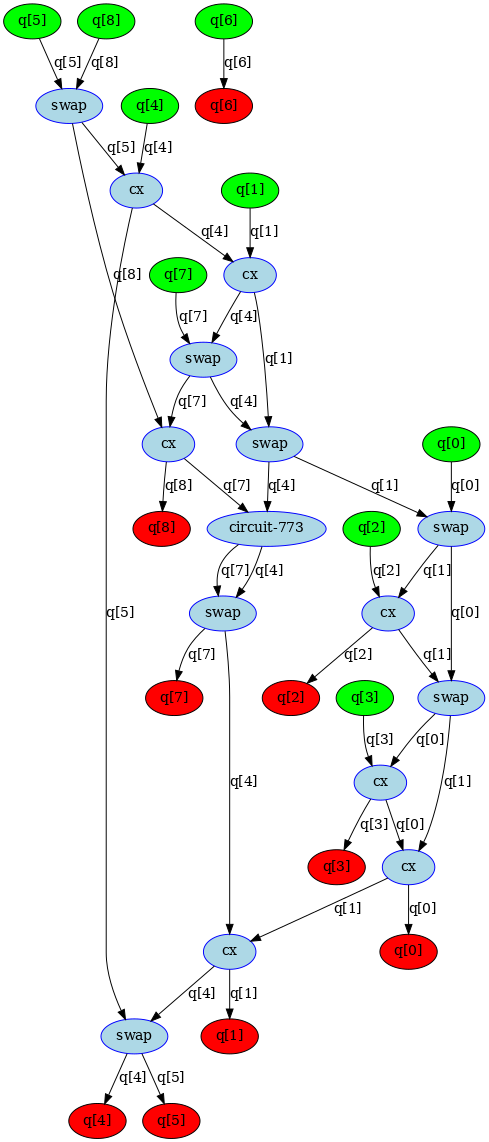

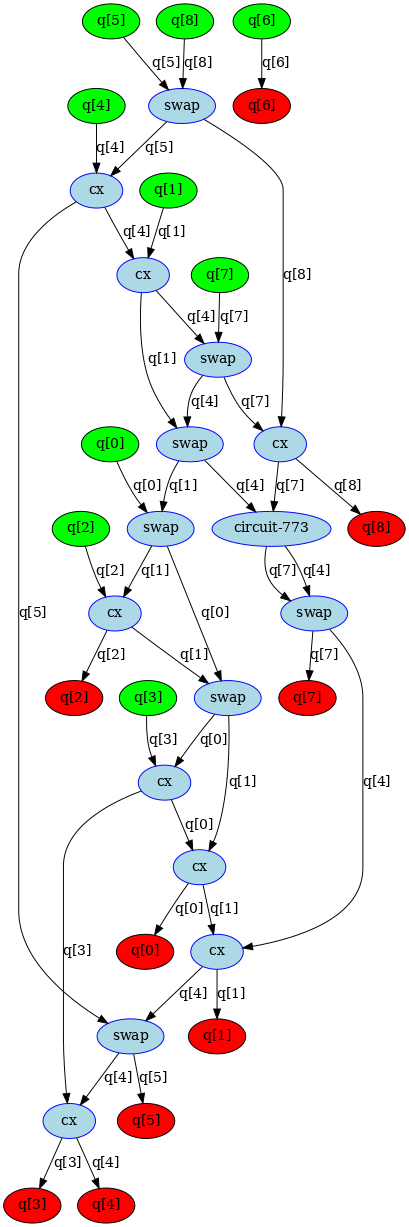

In [272]:
snapshots = pm.property_set["mapped_dag_snaps"]
for snap in snapshots:
    display(snap)

In [99]:
# get layers of the DAG

"""A layer is a circuit whose gates act on disjoint qubits, i.e., a layer has depth 1. The total number of layers equals the circuit depth d. The layers are indexed from 0 to d-1 with the earliest layer at index 0. The layers are constructed using a greedy algorithm. Each returned layer is a dict containing {“graph”: circuit graph, “partition”: list of qubit lists}.

The returned layer contains new (but semantically equivalent) DAGOpNodes, DAGInNodes, and DAGOutNodes. These are not the same as nodes of the original dag, but are equivalent via DAGNode.semantic_eq(node1, node2)."""

# convert generator to list
layers = list(dag.layers())
for layer in layers:
    print(layer)

# # get serial layers
# """A serial layer is a circuit with one gate. The layers have the same structure as in layers()."""
# serial_layers = dag.serial_layers()
# for layer in serial_layers:
#     print(layer)

# # get multigraph layers
# multi_layers = dag.multigraph_layers()
# for layer in multi_layers:
#     print(layer)

{'graph': <qiskit.dagcircuit.dagcircuit.DAGCircuit object at 0x7fdafbb89190>, 'partition': [(Qubit(QuantumRegister(16, 'q1'), 11), Qubit(QuantumRegister(16, 'q1'), 12)), (Qubit(QuantumRegister(16, 'q1'), 7), Qubit(QuantumRegister(16, 'q1'), 14)), (Qubit(QuantumRegister(16, 'q1'), 8), Qubit(QuantumRegister(16, 'q1'), 10))]}
{'graph': <qiskit.dagcircuit.dagcircuit.DAGCircuit object at 0x7fdafbb89df0>, 'partition': [(Qubit(QuantumRegister(16, 'q1'), 11), Qubit(QuantumRegister(16, 'q1'), 1)), (Qubit(QuantumRegister(16, 'q1'), 8), Qubit(QuantumRegister(16, 'q1'), 0)), (Qubit(QuantumRegister(16, 'q1'), 13), Qubit(QuantumRegister(16, 'q1'), 10))]}
{'graph': <qiskit.dagcircuit.dagcircuit.DAGCircuit object at 0x7fdafbb89e50>, 'partition': [(Qubit(QuantumRegister(16, 'q1'), 4), Qubit(QuantumRegister(16, 'q1'), 1))]}
{'graph': <qiskit.dagcircuit.dagcircuit.DAGCircuit object at 0x7fdafbb89460>, 'partition': [(Qubit(QuantumRegister(16, 'q1'), 1), Qubit(QuantumRegister(16, 'q1'), 7)), (Qubit(Quantum

In [100]:
# want to get topological distance from output F and inputs to F'
F = layers[0]["graph"]
F_prime = layers[1]["graph"]

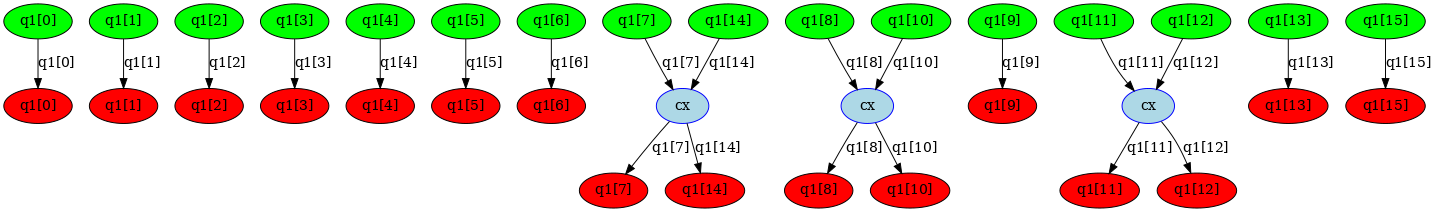

In [101]:
F.draw()

In [102]:
# work on getting output permutations from a single layer
# this includes virtual swaps + slack swaps that don't affect the depth
v_to_p = layout.get_virtual_bits()

In [103]:
# induce the SWAPs on a layer
set_pass = SetLayout(layout)
F_swapped = set_pass.run(F)
apply_pass = ApplyLayout()
apply_pass.property_set = set_pass.property_set
F_swapped = apply_pass.run(F_swapped)
swapper = BasicSwap(coupling)
swapper.property_set = set_pass.property_set
F_swapped = swapper.run(F_swapped)

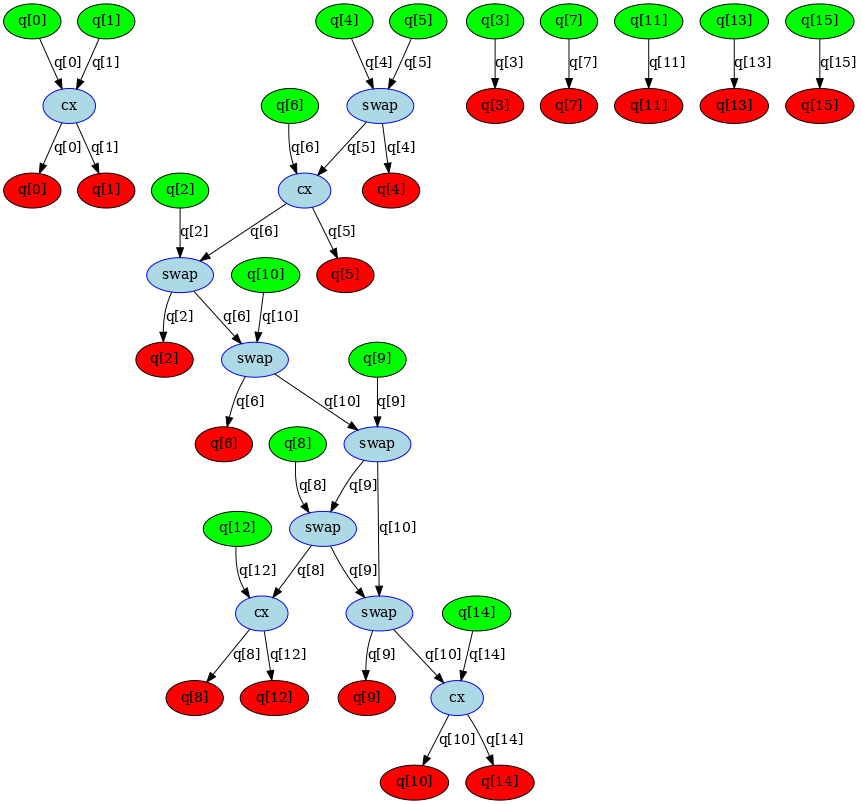

In [86]:
F_swapped.draw()

In [91]:
swapper.property_set["final_layout"]
# for x in F_swapped.output_map.items():
#     print(x)

Layout({
0: Qubit(QuantumRegister(16, 'q'), 0),
1: Qubit(QuantumRegister(16, 'q'), 1),
3: Qubit(QuantumRegister(16, 'q'), 3),
7: Qubit(QuantumRegister(16, 'q'), 7),
11: Qubit(QuantumRegister(16, 'q'), 11),
12: Qubit(QuantumRegister(16, 'q'), 12),
13: Qubit(QuantumRegister(16, 'q'), 13),
14: Qubit(QuantumRegister(16, 'q'), 14),
15: Qubit(QuantumRegister(16, 'q'), 15),
4: Qubit(QuantumRegister(16, 'q'), 5),
5: Qubit(QuantumRegister(16, 'q'), 4),
2: Qubit(QuantumRegister(16, 'q'), 6),
6: Qubit(QuantumRegister(16, 'q'), 10),
8: Qubit(QuantumRegister(16, 'q'), 2),
9: Qubit(QuantumRegister(16, 'q'), 9),
10: Qubit(QuantumRegister(16, 'q'), 8)
})

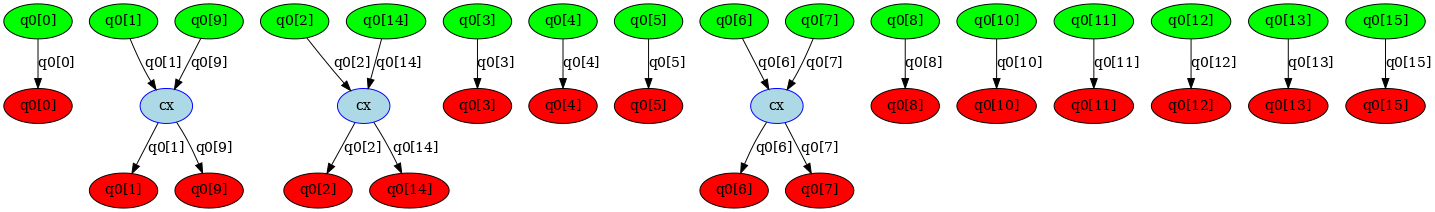

In [87]:
F_prime.draw()

In [68]:
for x in F_prime.input_map.items():
    print(x)

(Qubit(QuantumRegister(16, 'q0'), 0), DAGInNode(wire=Qubit(QuantumRegister(16, 'q0'), 0)))
(Qubit(QuantumRegister(16, 'q0'), 1), DAGInNode(wire=Qubit(QuantumRegister(16, 'q0'), 1)))
(Qubit(QuantumRegister(16, 'q0'), 2), DAGInNode(wire=Qubit(QuantumRegister(16, 'q0'), 2)))
(Qubit(QuantumRegister(16, 'q0'), 3), DAGInNode(wire=Qubit(QuantumRegister(16, 'q0'), 3)))
(Qubit(QuantumRegister(16, 'q0'), 4), DAGInNode(wire=Qubit(QuantumRegister(16, 'q0'), 4)))
(Qubit(QuantumRegister(16, 'q0'), 5), DAGInNode(wire=Qubit(QuantumRegister(16, 'q0'), 5)))
(Qubit(QuantumRegister(16, 'q0'), 6), DAGInNode(wire=Qubit(QuantumRegister(16, 'q0'), 6)))
(Qubit(QuantumRegister(16, 'q0'), 7), DAGInNode(wire=Qubit(QuantumRegister(16, 'q0'), 7)))
(Qubit(QuantumRegister(16, 'q0'), 8), DAGInNode(wire=Qubit(QuantumRegister(16, 'q0'), 8)))
(Qubit(QuantumRegister(16, 'q0'), 9), DAGInNode(wire=Qubit(QuantumRegister(16, 'q0'), 9)))
(Qubit(QuantumRegister(16, 'q0'), 10), DAGInNode(wire=Qubit(QuantumRegister(16, 'q0'), 10)